In [1056]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.model_selection import cross_val_score



In [1057]:
#loading data
df = pd.read_csv("features_30_sec.csv")

#removing any missing values
df = df.dropna()

#print(df.head())

#encoding categorical genre labels to numerical labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

Printing the number of features in the CSV

In [1058]:
#counting the columns in the CSV file
import csv

with open('features_30_sec.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    first_row = next(reader)  # Read the first row of the CSV file
    num_columns = len(first_row)
    print("number of columns:", num_columns)

number of columns: 60


Printing all unique genres and their counts

In [1059]:
print("genre counts:\n", df["label"].value_counts())

genre counts:
 label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64


Visualising the data distirbution with a bar chart

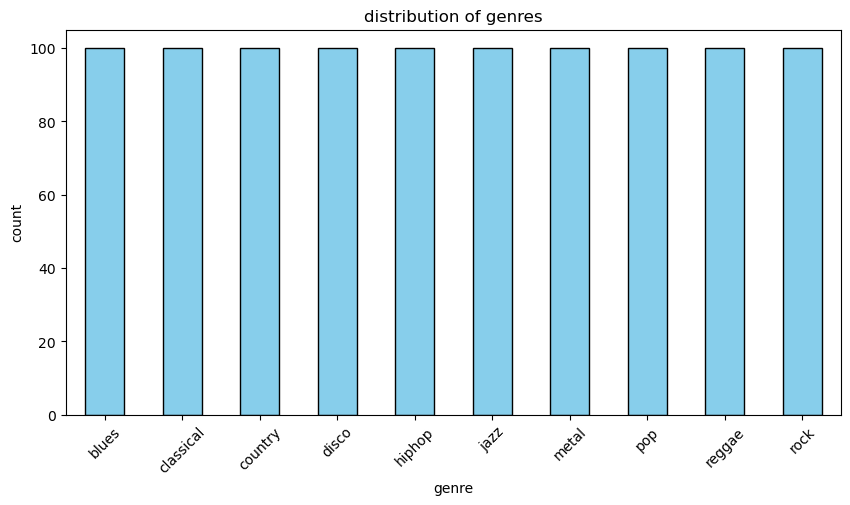

In [1060]:
plt.figure(figsize=(10, 5))
df["label"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("genre")
plt.ylabel("count")
plt.title("distribution of genres")
plt.xticks(rotation=45)
plt.show()

Preparing features (X) by dropping non-feature columns and defining the target (y)

In [1061]:
X = df.drop(["label", "label_encoded", "filename", "harmony_mean", 
             "mfcc19_mean", "mfcc20_mean", "perceptr_mean", 
             "zero_crossing_rate_var", "perceptr_var", "rms_var"], 
             axis=1, errors="ignore")

y = df["label_encoded"]

Splitting the data into training sets and test sets 80/20

In [1062]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [1063]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

#scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)  


#applying PCA
pca = PCA(n_components=40)  #keeping 40 components
X_train_pca = pca.fit_transform(X_train_scaled)  #fitting PCA on training data
X_test_pca = pca.transform(X_test_scaled)  #transforming test data with PCA

#printing number of components selected
print("number of PCA components selected:", pca.n_components_)


number of PCA components selected: 40


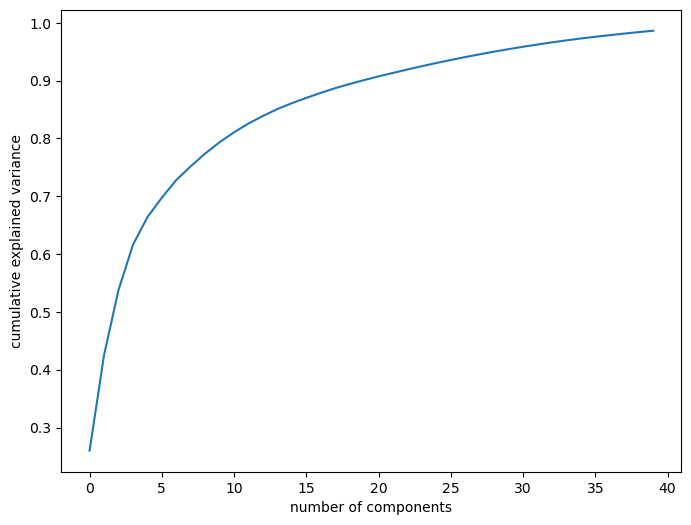

In [1064]:
#plotting cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance)
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.show()


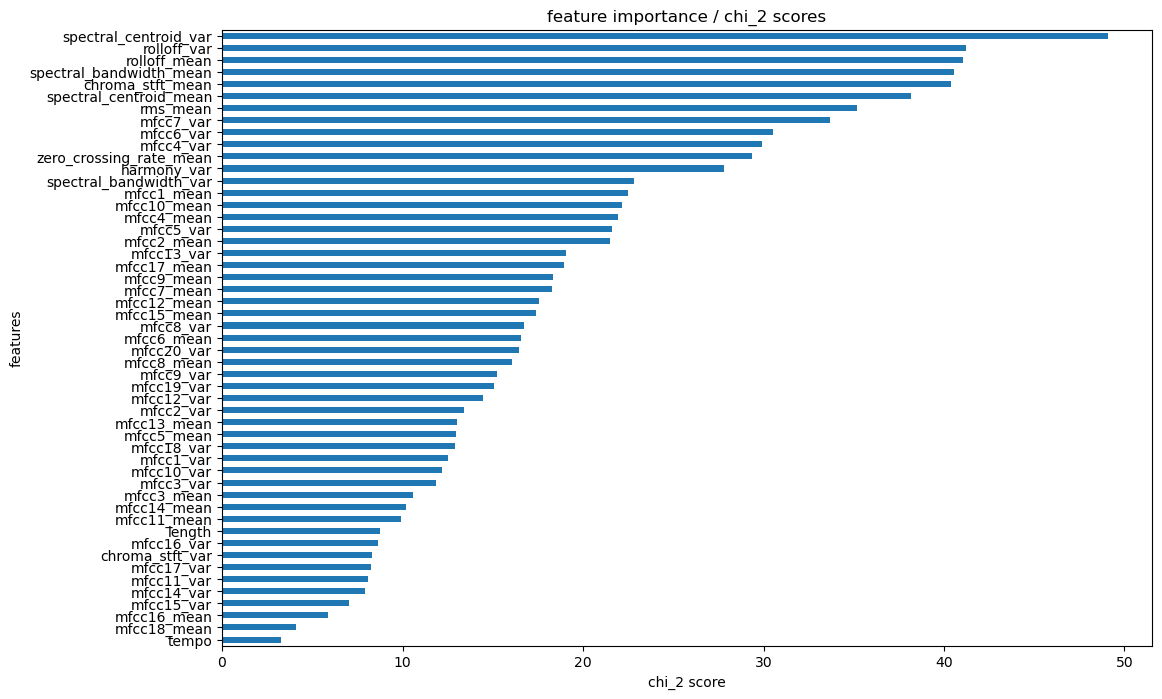

In [1065]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

#applying chi_2 feature selection
chi2_selector = SelectKBest(score_func=chi2, k='all').fit(X_scaled, y)  # Select all to view scores


##creating the dataframe with feature names and chi_2 scores
chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns).sort_values()

#plotting the chi_2 scores
plt.figure(figsize=(12, 8))
chi2_scores.plot(kind='barh')
plt.ylabel("features")
plt.xlabel("chi_2 score")
plt.title("feature importance / chi_2 scores")
plt.show()

In [1066]:
#training SVC model
svc_model = SVC(kernel="rbf", random_state=42)
svc_model.fit(X_train_pca, y_train)

#training random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [1067]:
#training accuracy
y_train_pred_svc = svc_model.predict(X_train_pca)
y_train_pred_rf = rf_model.predict(X_train_scaled)

print("training accuracy (SVC):", accuracy_score(y_train, y_train_pred_svc))
print("training accuracy (RF):", accuracy_score(y_train, y_train_pred_rf))


training accuracy (SVC): 0.85125
training accuracy (RF): 0.99875


Clear signs of overfitting with Random Forest

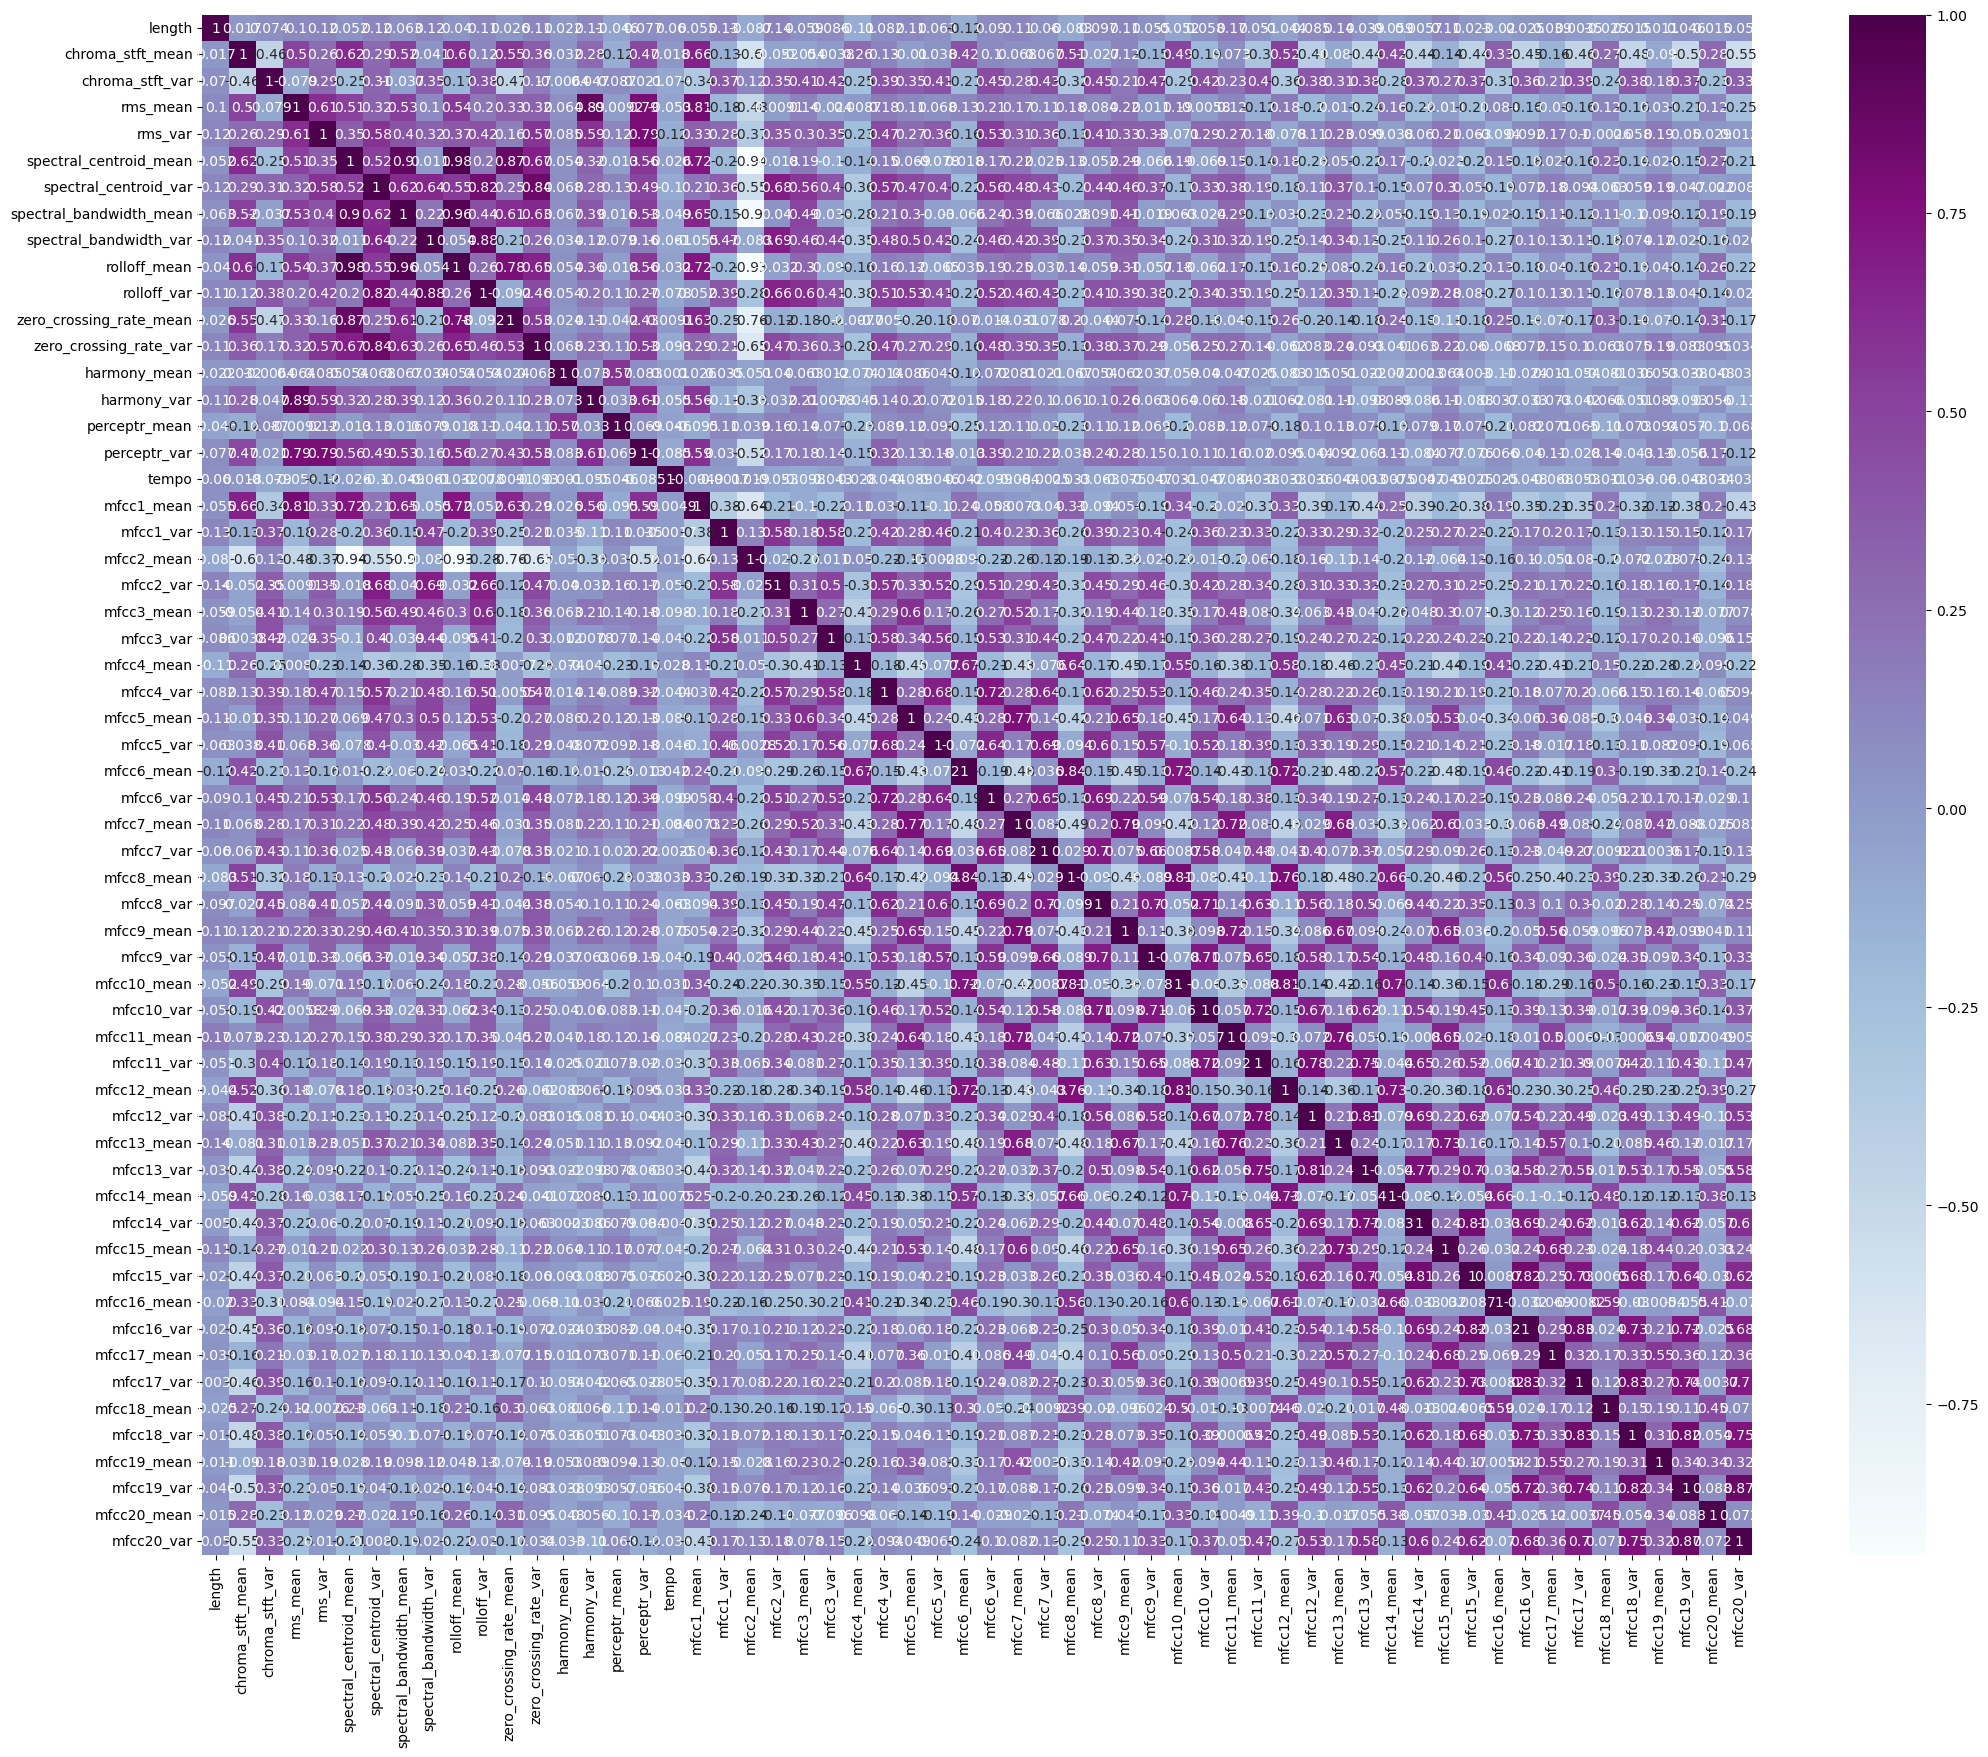

In [1068]:
#feature correlation heatmap for further feature selection

#dropping label, label encoded and the filename
features = df.drop(["label", "label_encoded", "filename"], axis=1, errors='ignore')
plt.figure(figsize=(25, 20))
sns.heatmap(features.corr(), annot=True, cmap="BuPu")
plt.show()

Limiting tree depth to prevent overfitting

In [1069]:
rf_model = RandomForestClassifier(
    n_estimators=100,         #100 trees
    max_depth=5,             #preventing deep trees
    min_samples_split=15,      
    min_samples_leaf=6,       
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

y_train_pred_rf = rf_model.predict(X_train_scaled)

print("updated training accuracy (RF):", accuracy_score(y_train, y_train_pred_rf))

updated training accuracy (RF): 0.8375


Training the test data

In [1070]:
#predictions on test data
y_pred_svc = svc_model.predict(X_test_pca)
y_pred_rf = rf_model.predict(X_test_scaled)

#test accuracy
print("test accuracy (SVC):", accuracy_score(y_test, y_pred_svc))
print("test accuracy (RF):", accuracy_score(y_test, y_pred_rf))

#classification reports
print("\nSVC classification report:\n", classification_report(y_test, y_pred_svc, target_names=le.classes_))
print("\nRandom Forest classification report:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))

#evaluating the models
y_pred_svc = svc_model.predict(X_test_pca)
y_pred_rf = rf_model.predict(X_test_scaled)

test accuracy (SVC): 0.74
test accuracy (RF): 0.715

SVC classification report:
               precision    recall  f1-score   support

       blues       0.88      0.75      0.81        20
   classical       0.83      1.00      0.91        20
     country       0.89      0.85      0.87        20
       disco       0.53      0.45      0.49        20
      hiphop       0.73      0.80      0.76        20
        jazz       0.80      0.80      0.80        20
       metal       0.76      0.80      0.78        20
         pop       0.83      0.75      0.79        20
      reggae       0.58      0.70      0.64        20
        rock       0.56      0.50      0.53        20

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.74      0.74      0.74       200


Random Forest classification report:
               precision    recall  f1-score   support

       blues       0.61      0.70      0.65        20
   classical

Plotting the decision tree for Random Forest

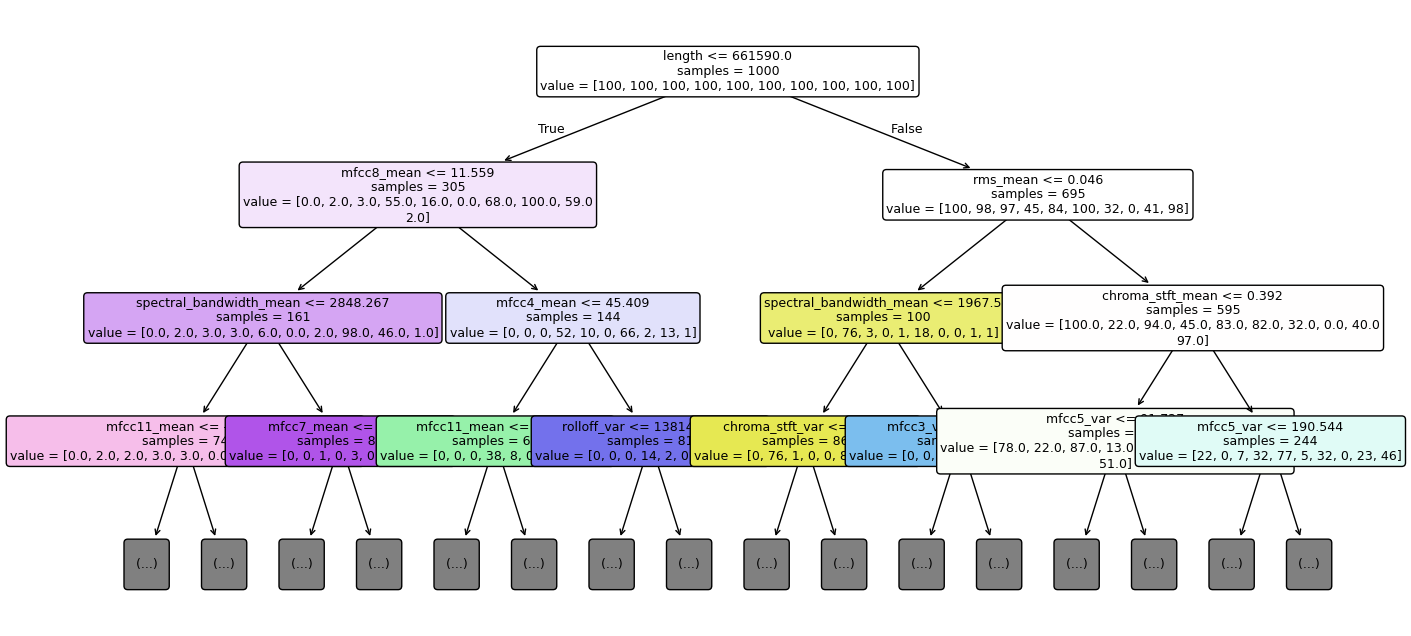

In [1071]:
from sklearn.tree import DecisionTreeClassifier, plot_tree 
learnt_model = DecisionTreeClassifier().fit(X, y)
plt.figure(figsize=(16, 8))
plot_tree(learnt_model, max_depth=3, feature_names=list(X.columns),
fontsize=9, filled=True, impurity=False, rounded=True) 
plt.show()

Plotting the Confusion Matrices for SVC and Random Forest

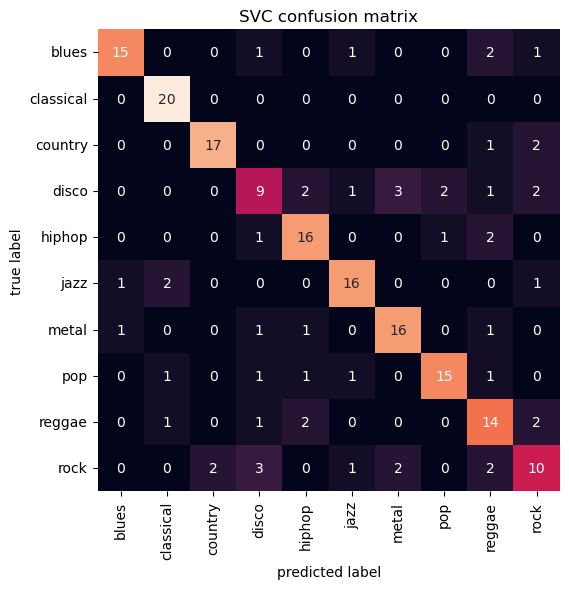

In [1072]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt="d", cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_, square=True)
plt.title("SVC confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

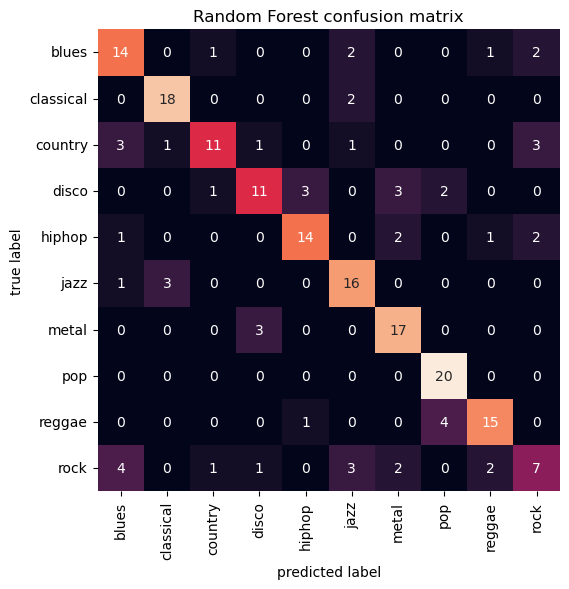

In [1073]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_, square=True)
plt.title("Random Forest confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

In [1074]:
from sklearn.model_selection import cross_val_score
import numpy as np

#computing 5 fold cross calidation scores
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)

print("RF Cross-Validation scores:\n", rf_cv_scores)
print("mean CV accuracy:", np.mean(rf_cv_scores))


RF Cross-Validation scores:
 [0.74375 0.6625  0.74375 0.63125 0.65625]
mean CV accuracy: 0.6875


In [1075]:
from sklearn.model_selection import cross_val_score
import numpy as np

svc_cv_scores = cross_val_score(svc_model, X_train_pca, y_train, cv=5)
print("SVC Cross-Validation scores\n", svc_cv_scores)
print("mean CV accuracy (SVC):", np.mean(svc_cv_scores))


SVC Cross-Validation scores
 [0.74375 0.65    0.725   0.71875 0.6625 ]
mean CV accuracy (SVC): 0.7
